## 🏨 Tourism Operations Manager: Advanced Mobility Analysis
**Role:** Tourism Operations Manager (Product Development & Marketing) 

**Objective:** Leverage taxi GPS data to identify high-value tourism patterns, validate nightlife economy demand, and discover new "Shadow Zones" for product development.

In [9]:
# Install all required libraries for the Tourism Analysis
%pip install pandas numpy matplotlib seaborn folium scikit-learn pyarrow fastparquet

Note: you may need to restart the kernel to use updated packages.


### 1. Environment Setup & Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# --- 1. CONFIGURATION ---
# Path to your Taxi Data (Root Folder)
TAXI_DATA_PATH = '/Users/nipunkharuehapaisarn/Desktop/Senior Project/taxi_processed.parquet'
# Path to your Tourist CSV
TOURIST_CSV_PATH = '/Users/nipunkharuehapaisarn/Desktop/Senior Project/Thailand Tourist Destinations.csv'

# --- 2. LOAD TAXI DATA (SMART IMPORT) ---
print("⏳ Loading Taxi Data (High Season: Jan-Feb 2023)...")
try:
    # Filter for High Season (Jan-Feb 2023) to optimize memory
    df_taxi = pd.read_parquet(
        TAXI_DATA_PATH,
        engine='pyarrow',
        columns=['vehicle_id', 'timestamp', 'lat', 'lon', 'speed', 'for_hire_light'],
        filters=[
            ('year', '=', 2023),
            ('month', 'in', [1, 2])
        ]
    )
    print(f"✅ Taxi Data Loaded: {len(df_taxi):,} rows")
except Exception as e:
    print(f"❌ Taxi Data Error: {e}")

# --- 3. LOAD TOURIST DESTINATIONS ---
print("⏳ Loading Tourist Destinations...")
try:
    df_tourist = pd.read_csv(TOURIST_CSV_PATH)
    # Rename columns for easier access
    df_tourist = df_tourist.rename(columns={'@lat': 'lat', '@lon': 'lon', 'name:en': 'name'})
    
    # Filter for relevant categories
    # 1. Cultural (Temples/Museums)
    cultural_spots = df_tourist[df_tourist['tourism'].isin(['attraction', 'museum', 'viewpoint'])]
    # 2. Lifestyle (Malls/Markets) - Using 'amenity' or 'shop' columns if available
    lifestyle_spots = df_tourist[df_tourist['amenity'].isin(['marketplace', 'nightclub', 'bar']) | 
                                 df_tourist['shop'].isin(['mall', 'department_store'])]
    
    print(f"✅ Tourist Data Loaded: {len(df_tourist)} locations")
    print(f"   - Cultural Spots: {len(cultural_spots)}")
    print(f"   - Lifestyle/Nightlife: {len(lifestyle_spots)}")
    
except Exception as e:
    print(f"❌ Tourist CSV Error: {e}")

⏳ Loading Taxi Data (High Season: Jan-Feb 2023)...
✅ Taxi Data Loaded: 7,457,488 rows
⏳ Loading Tourist Destinations...


### 2. Data Loading & Preprocessing
We define "Nightlife" specifically for Bangkok (7 PM - 2 AM).

In [ ]:
# --- PREPROCESSING ---

# 1. Convert timestamp to datetime (if needed)
df_taxi['timestamp'] = pd.to_datetime(df_taxi['timestamp'])
df_taxi['hour'] = df_taxi['timestamp'].dt.hour

# 2. Define Shifts (Revised for 'Dinner Rush' 18:00 start)
def get_shift(h):
    if 9 <= h <= 16:
        return 'Day Peak (Sightseeing)'
    elif 18 <= h or h <= 2:  # Starts at 18:00 to catch dinner crowd
        return 'Night Peak (Entertainment)'
    else:
        return 'Other'

# 3. Apply the function
df_taxi['shift'] = df_taxi['hour'].apply(get_shift)

# 4. CREATE THE MISSING VARIABLE
# This is the line your code was looking for!
df_analysis = df_taxi[df_taxi['shift'] != 'Other'].copy()

print(f"✅ df_analysis created with {len(df_analysis):,} rows.")

✅ df_analysis created with 5,406,556 rows.


### Economy Analysis (Driver Utilization)
* Goal: Prove that night tourism is efficient and profitable for drivers.
* Metric: Compare how often taxis are hired vs. cruising emp

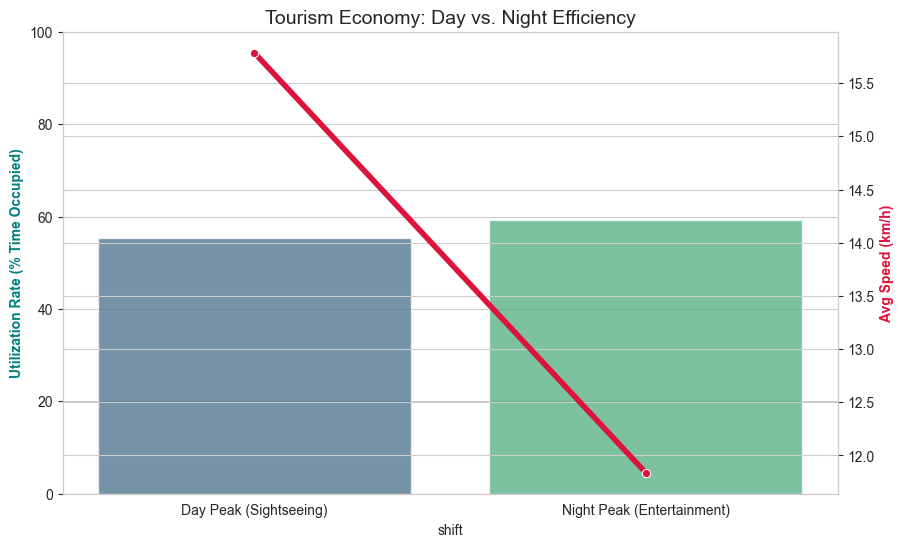

                        shift  Utilization Rate (%)  Avg Speed (km/h)
0      Day Peak (Sightseeing)             55.254736         15.785967
1  Night Peak (Entertainment)             59.160704         11.837644


In [ ]:
# --- ECONOMY ANALYSIS ---
# 1. Utilization Rate: % of time the taxi is Occupied (for_hire_light == 0)
# We group by the 'shift' column you just created
utilization = df_analysis.groupby('shift')['for_hire_light'].apply(
    lambda x: (x == 0).mean() * 100
).reset_index(name='Utilization Rate (%)')

# 2. Average Speed: Measures traffic flow
speed = df_analysis.groupby('shift')['speed'].mean().reset_index(name='Avg Speed (km/h)')

# 3. Merge metrics into one table
economy_stats = pd.merge(utilization, speed, on='shift')

# --- VISUALIZATION ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar Chart (Utilization)
sns.barplot(data=economy_stats, x='shift', y='Utilization Rate (%)', ax=ax1, palette='viridis', alpha=0.7)
ax1.set_ylabel('Utilization Rate (% Time Occupied)', color='teal', fontweight='bold')
ax1.set_ylim(0, 100)

# Line Chart (Speed)
ax2 = ax1.twinx()
sns.lineplot(data=economy_stats, x='shift', y='Avg Speed (km/h)', ax=ax2, color='crimson', marker='o', linewidth=4)
ax2.set_ylabel('Avg Speed (km/h)', color='crimson', fontweight='bold')

plt.title('Tourism Economy: Day vs. Night Efficiency', fontsize=14)
plt.show()

# Print the numbers for your report
print(economy_stats)

### Trajectory Analysis (The "Nightlife Circuit")
* Goal: Map the actual paths tourists take from Riverside Hotels to Nightlife Zones.
* Updates: Includes the "Ghost Trip" cleaner (removes trips < 5 mins) to ensure accuracy.

In [ ]:
# --- ADVANCED TRAJECTORY ANALYSIS (Clustering Approach) ---
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import matplotlib.colors as colors

print("🚀 Starting Data-Driven Trajectory Analysis...")

# 1. IDENTIFY TRIPS (Start & End Points)
# Sort by vehicle and time
df_sorted = df_analysis.sort_values(['vehicle_id', 'timestamp'])
df_sorted['prev_light'] = df_sorted.groupby('vehicle_id')['for_hire_light'].shift(1)
df_sorted['trip_change'] = (df_sorted['for_hire_light'] != df_sorted['prev_light']).astype(int)
df_sorted['trip_id'] = df_sorted.groupby('vehicle_id')['trip_change'].cumsum()

# Aggregate Start/End Coordinates
trips = df_sorted[df_sorted['for_hire_light'] == 0].groupby(['vehicle_id', 'trip_id']).agg(
    start_time=('timestamp', 'min'),
    start_lat=('lat', 'first'),
    start_lon=('lon', 'first'),
    end_lat=('lat', 'last'),
    end_lon=('lon', 'last'),
    duration_min=('timestamp', lambda x: (x.max() - x.min()).total_seconds() / 60)
).reset_index()

# Filter: Valid Trips (5 mins to 3 hours) & Night Shift
valid_trips = trips[
    (trips['duration_min'] > 5) & 
    (trips['duration_min'] < 180) &
    (trips['start_time'].dt.hour >= 18) # Night Shift
].copy()

print(f"✅ Analyzed {len(valid_trips)} valid night trips.")

# 2. CLUSTER ORIGINS (The "Proper" Way)
# Instead of hard-coding 'Riverside', we let DBSCAN find the hotspots.
print("🤖 Clustering start locations to find major hubs...")

coords = valid_trips[['start_lat', 'start_lon']].values

# eps=0.003 is approx 300 meters. min_samples=50 means a hub needs 50+ trips.
db = DBSCAN(eps=0.003, min_samples=50, metric='euclidean').fit(coords)
valid_trips['origin_cluster'] = db.labels_

# Get Top 3 Clusters (excluding noise -1)
top_hubs = valid_trips[valid_trips['origin_cluster'] != -1]['origin_cluster'].value_counts().head(3).index.tolist()
print(f"🏆 Top 3 Origin Hubs Identified: {top_hubs}")

# 3. VISUALIZE FLOWS
m_traj = folium.Map(location=[13.75, 100.51], zoom_start=12, tiles='CartoDB positron')

# Color Palette for the 3 Hubs
hub_colors = ['#e74c3c', '#3498db', '#2ecc71'] # Red, Blue, Green
hub_names = ['Primary Hub (e.g. Sukhumvit)', 'Secondary Hub (e.g. Siam)', 'Tertiary Hub (e.g. Riverside)']

legend_html = """
<div style="position: fixed; bottom: 30px; right: 30px; width: 180px; 
background-color: white; border:2px solid grey; z-index:9999; padding: 10px; border-radius: 5px; font-size:12px;">
<b>Top 3 Origin Flows</b><br>
"""

for i, cluster_id in enumerate(top_hubs):
    # Filter trips for this cluster
    hub_trips = valid_trips[valid_trips['origin_cluster'] == cluster_id]
    color = hub_colors[i]
    
    # Calculate Center of Hub (for Marker)
    center_lat = hub_trips['start_lat'].mean()
    center_lon = hub_trips['start_lon'].mean()
    
    # Add Hub Marker
    folium.Marker(
        [center_lat, center_lon],
        icon=folium.Icon(color='white', icon_color=color, icon='star', prefix='fa'),
        popup=f"<b>Hub #{i+1}</b><br>Trips: {len(hub_trips)}"
    ).add_to(m_traj)
    
    # Draw Trajectories (Sample 50 per hub to avoid crash)
    for _, row in hub_trips.sample(min(50, len(hub_trips))).iterrows():
        folium.PolyLine(
            locations=[[row['start_lat'], row['start_lon']], [row['end_lat'], row['end_lon']]],
            color=color, weight=1.5, opacity=0.6
        ).add_to(m_traj)
        
        # Add Destination Dot
        folium.CircleMarker(
            [row['end_lat'], row['end_lon']],
            radius=2, color=color, fill=True
        ).add_to(m_traj)

    # Add to Legend
    legend_html += f'<i style="background:{color}; width:10px; height:10px; display:inline-block;"></i> Hub #{i+1} ({len(hub_trips)} trips)<br>'

legend_html += "</div>"
m_traj.get_root().html.add_child(folium.Element(legend_html))

# Save & Display
m_traj.save("trajectory_analysis_smart.html")
print("✅ Map saved as 'trajectory_analysis_smart.html'.")

from IPython.display import IFrame
IFrame("trajectory_analysis_smart.html", width=1000, height=600)

🚀 Starting Data-Driven Trajectory Analysis...
✅ Analyzed 49608 valid night trips.
🤖 Clustering start locations to find major hubs...
🏆 Top 3 Origin Hubs Identified: [1, 4, 11]
✅ Map saved as 'trajectory_analysis_smart.html'.


### Part 1: The Congestion Analysis
Copy this block into your notebook. It calculates traffic for every row in your CSV file.

In [ ]:
# --- ADVANCED CONGESTION ANALYSIS (Comprehensive Categorization) ---
from sklearn.neighbors import BallTree

print("🚀 Starting Full-Scale Congestion Analysis...")

# 1. ROBUST CATEGORY MAPPING
# Maps keywords in 'shop', 'amenity', 'tourism' to readable Groups
CATEGORY_MAP = {
    # Shopping
    'mall': 'Shopping Mall', 'department_store': 'Shopping Mall',
    'marketplace': 'Market', 'supermarket': 'Market', 'convenience': 'Market',
    # Nightlife
    'nightclub': 'Nightlife', 'bar': 'Nightlife', 'club': 'Nightlife',
    'cinema': 'Nightlife', 'theatre': 'Nightlife',
    # Culture
    'place_of_worship': 'Temple', 'monastery': 'Temple',
    'museum': 'Culture', 'arts_centre': 'Culture', 'artwork': 'Culture',
    # Attraction
    'attraction': 'Attraction', 'viewpoint': 'Attraction',
    'zoo': 'Attraction', 'aquarium': 'Attraction', 'theme_park': 'Attraction',
    # Lifestyle
    'restaurant': 'Food & Dining', 'food_court': 'Food & Dining', 'cafe': 'Food & Dining',
    'spa': 'Wellness', 'massage': 'Wellness'
}

def resolve_category(row):
    name = str(row.get('name', '')).lower()
    
    # 1. FIX: Explicitly catch 'Wat' (Temple)
    if 'wat ' in name or name.startswith('wat'):
        return 'Temple'
        
    # 2. Check columns in priority
    for col in ['tourism', 'amenity', 'shop']:
        val = str(row.get(col, '')).lower()
        if val in CATEGORY_MAP:
            return CATEGORY_MAP[val]
            
    return 'Other'

df_targets = df_tourist.dropna(subset=['lat', 'lon', 'name']).copy()
df_targets['Category'] = df_targets.apply(resolve_category, axis=1)

print(f"📍 Categorized {len(df_targets)} locations.")

# 2. SPATIAL INDEXING (BallTree)
tourist_rad = np.radians(df_targets[['lat', 'lon']].values)

df_dropoffs = df_analysis[df_analysis['for_hire_light'] == 1]
df_day = df_dropoffs[df_dropoffs['shift'] == 'Day Peak (Sightseeing)']
df_night = df_dropoffs[df_dropoffs['shift'] == 'Night Peak (Entertainment)']

tree_day = BallTree(np.radians(df_day[['lat', 'lon']].values), metric='haversine')
tree_night = BallTree(np.radians(df_night[['lat', 'lon']].values), metric='haversine')
radius_rad = 400 / 6371000 

print("🔍 Querying traffic density...")
day_counts = tree_day.query_radius(tourist_rad, r=radius_rad, count_only=True)
night_counts = tree_night.query_radius(tourist_rad, r=radius_rad, count_only=True)

# 3. AGGREGATE
df_targets['Day_Traffic'] = day_counts
df_targets['Night_Traffic'] = night_counts
df_targets['Total_Traffic'] = day_counts + night_counts

# Remove Zero Traffic & Aggregate Duplicates
df_clean = df_targets[df_targets['Total_Traffic'] > 0].copy()

df_final = df_clean.groupby('name').agg({
    'Day_Traffic': 'sum',
    'Night_Traffic': 'sum',
    'Total_Traffic': 'sum',
    'lat': 'mean', 'lon': 'mean',
    'Category': 'first' 
}).reset_index()

df_final['Night_Ratio'] = (df_final['Night_Traffic'] / df_final['Total_Traffic']).fillna(0.0)
int_cols = ['Day_Traffic', 'Night_Traffic', 'Total_Traffic']
df_final[int_cols] = df_final[int_cols].astype(int)

print(f"✅ Analysis Complete. Found {len(df_final)} active spots.")

🚀 Starting Full-Scale Congestion Analysis...
📍 Categorized 3946 locations.
🔍 Querying traffic density...
✅ Analysis Complete. Found 587 active spots.


### Dominance Map (Day vs. Night Hotspots)
Now that we have calculated values for everything, we visualize the Top 200 spots. (Visualizing all 5,000+ points would make the map unreadable and slow).

In [ ]:
# --- ADVANCED COMPARISON MAP (Dynamic Legend) ---
import folium
from IPython.display import IFrame

# 1. SETUP COLORS
COLOR_MAP = {
    'Shopping Mall': '#9b59b6',  # Purple
    'Market': '#e67e22',         # Orange
    'Nightlife': '#e74c3c',      # Red
    'Temple': '#f1c40f',         # Gold
    'Culture': '#34495e',        # Dark Blue
    'Attraction': '#3498db',     # Blue
    'Food & Dining': '#2ecc71',  # Green
    'Wellness': '#1abc9c',       # Teal
    'Other': '#95a5a6'           # Gray
}

m_compare = folium.Map(location=[13.75, 100.51], zoom_start=12, tiles='CartoDB positron')

# 2. CREATE LAYERS
fg_dominance = folium.FeatureGroup(name="1. Dominance View (Category Colors)", show=True)
fg_day = folium.FeatureGroup(name="2. 🌞 Day Intensity", show=False)
fg_night = folium.FeatureGroup(name="3. 🌙 Night Intensity", show=False)

# Track which categories are actually used (for the Legend)
used_categories = set()

# 3. PLOT TOP 200
top_200 = df_final.sort_values('Total_Traffic', ascending=False).head(200)
print(f"🗺️ Generating Map for Top {len(top_200)} locations...")

for _, row in top_200.iterrows():
    cat = row['Category']
    cat_color = COLOR_MAP.get(cat, '#95a5a6')
    used_categories.add(cat) # Add to set for legend later
    
    total = row['Total_Traffic']
    
    # Popup
    popup_html = f"""
    <div style="font-family: sans-serif; width: 200px;">
        <h4 style="margin:0; color:{cat_color};">{row['name']}</h4>
        <span style="background:{cat_color}; color:white; font-size:10px; padding:2px 5px; border-radius:3px;">{cat}</span>
        <hr style="margin:5px 0;">
        <div style="font-size:12px;">
            <b>Total Visits:</b> {total}<br>
            <span style="color:#2980b9;">🌞 Day: {row['Day_Traffic']}</span><br>
            <span style="color:#c0392b;">🌙 Night: {row['Night_Traffic']}</span>
        </div>
    </div>
    """

    # Layer 1: Dominance
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=np.log1p(total) * 2.5,
        color=cat_color, fill=True, fill_opacity=0.7,
        popup=folium.Popup(popup_html, max_width=250),
        tooltip=f"{row['name']} ({cat})"
    ).add_to(fg_dominance)

    # Layer 2: Day (Blue)
    if row['Day_Traffic'] > 0:
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=np.log1p(row['Day_Traffic']) * 2.5,
            color='#3498db', fill=True, fill_opacity=0.6,
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['name']} (Day)"
        ).add_to(fg_day)

    # Layer 3: Night (Red)
    if row['Night_Traffic'] > 0:
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=np.log1p(row['Night_Traffic']) * 2.5,
            color='#e74c3c', fill=True, fill_opacity=0.6,
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=f"{row['name']} (Night)"
        ).add_to(fg_night)

# 4. ADD LAYERS
m_compare.add_child(fg_dominance)
m_compare.add_child(fg_day)
m_compare.add_child(fg_night)
folium.LayerControl(collapsed=False).add_to(m_compare)

# 5. DYNAMIC LEGEND GENERATION
# Sort categories to match the Color Map order for consistency
sorted_cats = [cat for cat in COLOR_MAP.keys() if cat in used_categories]

legend_html = '''
     <div style="position: fixed; bottom: 30px; left: 30px; 
     border:2px solid grey; z-index:9999; font-size:12px;
     background-color:white; opacity:0.9; padding: 10px; border-radius:5px;">
     <b>Category Legend</b><br>
'''

for cat in sorted_cats:
    color = COLOR_MAP[cat]
    legend_html += f'<i style="background:{color}; width:10px; height:10px; display:inline-block; border-radius:50%; margin-right:5px;"></i> {cat}<br>'

legend_html += '</div>'
m_compare.get_root().html.add_child(folium.Element(legend_html))

# Save & Display
m_compare.save("dominance_compare_map_fixed.html")
print("✅ Map saved as 'dominance_compare_map_fixed.html'.")

IFrame("dominance_compare_map_fixed.html", width=1000, height=600)

🗺️ Generating Map for Top 200 locations...
✅ Map saved as 'dominance_compare_map_fixed.html'.


In [ ]:
# --- EXPORT & TABLE VIEW ---

# 1. PREPARE THE DATA FOR EXPORT
# Select relevant columns and rename for clarity
export_cols = ['name', 'Category', 'Total_Traffic', 'Day_Traffic', 'Night_Traffic', 'Night_Ratio', 'lat', 'lon']
df_export = df_final.sort_values('Total_Traffic', ascending=False)[export_cols].copy()

# Add a "Rank" column
df_export.insert(0, 'Rank', range(1, len(df_export) + 1))

# Format the Ratio as percentage for the CSV (e.g., 0.85 -> 85%)
df_export['Night_Share_Pct'] = (df_export['Night_Ratio'] * 100).round(1)

# 2. SAVE TO CSV (Files will appear in your project folder)
df_export.to_csv("dominance_analysis_full.csv", index=False)
df_export.head(20).to_csv("dominance_top_20.csv", index=False)

print(f"✅ Data Saved! Check your folder for:")
print(f"   - 'dominance_analysis_full.csv' ({len(df_export)} locations)")
print(f"   - 'dominance_top_20.csv'")

# 3. DISPLAY STYLED TOP 20 TABLE IN VS CODE
print("\n🏆 TOP 20 DOMINANCE LIST (Interactive Table):")

# Filter Top 20
top_20_view = df_export.head(20).copy()

# Define functions for styling
def color_night_ratio(val):
    """Colors the Night Ratio: Red=Night, Blue=Day, Purple=Mixed"""
    if val > 0.6: color = '#ffcccc' # Light Red
    elif val < 0.4: color = '#cce5ff' # Light Blue
    else: color = '#e6ccff' # Light Purple
    return f'background-color: {color}'

def make_bold(val):
    return 'font-weight: bold'

# Render the Table
# We use Pandas Styler to make it look professional in the notebook
display(
    top_20_view[['Rank', 'name', 'Category', 'Total_Traffic', 'Night_Share_Pct']]
    .style
    .format({'Night_Share_Pct': '{:.1f}%', 'Total_Traffic': '{:,}'}) # Format numbers
    .map(color_night_ratio, subset=['Night_Share_Pct']) # Color code the ratio
    .applymap(make_bold, subset=['Rank', 'name']) # Bold text
    .background_gradient(subset=['Total_Traffic'], cmap='Greens') # Green bar for volume
    .set_caption("Top 20 Most Visited Tourist Spots (Taxi Data)")
)

✅ Data Saved! Check your folder for:
   - 'dominance_analysis_full.csv' (587 locations)
   - 'dominance_top_20.csv'

🏆 TOP 20 DOMINANCE LIST (Interactive Table):


,Rank,name,Category,Total_Traffic,Night_Share_Pct
160,1,Golden Mount,Attraction,"19,840",33.6%
572,2,Yaowarat Road,Attraction,"18,418",39.8%
411,3,Si Bearing,Other,"17,735",53.5%
466,4,Tanao Road,Attraction,"11,464",43.6%
266,5,Makkasan,Other,"8,920",47.5%
53,6,Big C Supercenter,Shopping Mall,"8,111",46.6%
399,7,Samyan Mitrtown,Shopping Mall,"8,068",52.1%
452,8,Street market,Attraction,"8,054",29.4%
450,9,Street Food,Attraction,"7,975",36.8%
231,10,Lak Si,Other,"7,913",34.1%
